In [1]:
import os
import scipy.io as sio 
import numpy as np
from scipy.signal import cspline1d, cspline1d_eval

from operator import itemgetter

%matplotlib inline 
import matplotlib.pyplot as plt

from scipy.linalg import svd
from scipy import signal

In [2]:
class Denoiser(object):
    '''
    A class for smoothing a noisy, real-valued data sequence by means of SVD of a partial circulant matrix.
    -----
    Attributes:
        mode: str
            Code running mode: "layman" or "expert".
            In the "layman" mode, the code autonomously tries to find the optimal denoised sequence.
            In the "expert" mode, a user has full control over it.
        s: 1D array of floats
            Singular values ordered decreasingly.
        U: 2D array of floats
            A set of left singular vectors as the columns.
        r: int
            Rank of the approximating matrix of the constructed partial circulant matrix from the sequence.
    '''

    def __init__(self, mode="layman"):
        '''
        Class initialization.
        -----
        Arguments:
            mode: str
                Denoising mode. To be selected from ["layman", "expert"]. Default is "layman".
                While "layman" grants the code autonomy, "expert" allows a user to experiment.
        -----
        Raises:
            ValueError
                If mode is neither "layman" nor "expert".
        '''
        self._method = {"layman": self._denoise_for_layman, "expert": self._denoise_for_expert}
        if mode not in self._method:
            raise ValueError("unknown mode '{:s}'!".format(mode))
        self.mode = mode

    def _embed(self, x, m):
        '''
        Embed a 1D array into a 2D partial circulant matrix by cyclic left-shift.
        -----
        Arguments:
            x: 1D array of floats
                Input array.
            m: int
                Number of rows of the constructed matrix.
        -----
        Returns:
            X: 2D array of floats
                Constructed partial circulant matrix.
        '''
        x_ext = np.hstack((x, x[:m-1]))
        shape = (m, x.size)
        strides = (x_ext.strides[0], x_ext.strides[0])
        X = np.lib.stride_tricks.as_strided(x_ext, shape, strides)
        return X

    def _reduce(self, A):
        '''
        Reduce a 2D matrix to a 1D array by cyclic anti-diagonal average.
        -----
        Arguments:
            A: 2D array of floats
                Input matrix.
        -----
        Returns:
            a: 1D array of floats
                Output array.
        '''
        m = A.shape[0]
        A_ext = np.hstack((A[:,-m+1:], A))
        strides = (A_ext.strides[0]-A_ext.strides[1], A_ext.strides[1])
        a = np.mean(np.lib.stride_tricks.as_strided(A_ext[:,m-1:], A.shape, strides), axis=0)
        return a

    def _denoise_for_expert(self, sequence, layer, gap, rank):
        '''
        Smooth a noisy sequence by means of low-rank approximation of its corresponding partial circulant matrix.
        -----
        Arguments:
            sequence: 1D array of floats
                Data sequence to be denoised.
            layer: int
                Number of leading rows selected from the matrix.
            gap: float
                Gap between the data levels on the left and right ends of the sequence.
                A positive value means the right level is higher.
            rank: int
                Rank of the approximating matrix.
        -----
        Returns:
            denoised: 1D array of floats
                Smoothed sequence after denoise.
        -----
        Raises:
            AssertionError
                If condition 1 <= rank <= layer <= sequence.size cannot be fulfilled.
        '''
        assert 1 <= rank <= layer <= sequence.size
        self.r = rank
        # linear trend to be deducted
        trend = np.linspace(0, gap, sequence.size)
        X = self._embed(sequence-trend, layer)
        # singular value decomposition
        self.U, self.s, Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)
        # low-rank approximation
        A = self.U[:,:self.r] @ np.diag(self.s[:self.r]) @ Vh[:self.r]
        denoised = self._reduce(A) + trend
        return denoised

    def _cross_validate(self, x, m):
        '''
        Check if the gap of boundary levels of the detrended sequence is within the estimated noise strength.
        -----
        Arguments:
            x: 1D array of floats
                Input array.
            m: int
                Number of rows of the constructed matrix.
        -----
        Returns:
            valid: bool
                Result of cross validation. True means the detrending procedure is valid.
        '''
        X = self._embed(x, m)
        self.U, self.s, self._Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)
        # Search for noise components using the normalized mean total variation of the left singular vectors as an indicator.
        # The procedure runs in batch of every 10 singular vectors.
        self.r = 0
        while True:
            U_sub = self.U[:,self.r:self.r+10]
            NMTV = np.mean(np.abs(np.diff(U_sub,axis=0)), axis=0) / (np.amax(U_sub,axis=0) - np.amin(U_sub,axis=0))
            try:
                # the threshold of 10% can in most cases discriminate noise components
                self.r += np.argwhere(NMTV > .1)[0,0]
                break
            except IndexError:
                self.r += 10
        # estimate the noise strength, while r marks the first noise component
        noise_stdev = np.sqrt(np.sum(self.s[self.r:]**2) / X.size)
        # estimate the gap of boundary levels after detrend
        gap = np.abs(x[-self._k:].mean()-x[:self._k].mean())
        valid = gap < noise_stdev
        return valid

    def _denoise_for_layman(self, sequence, layer):
        '''
        Similar to the "expert" method, except that denoising parameters are optimized autonomously.
        -----
        Arguments:
            sequence: 1D array of floats
                Data sequence to be denoised.
            layer: int
                Number of leading rows selected from the corresponding circulant matrix.
        -----
        Returns:
            denoised: 1D array of floats
                Smoothed sequence after denoise.
        -----
        Raises:
            AssertionError
                If condition 1 <= layer <= sequence.size cannot be fulfilled.
        '''
        assert 1 <= layer <= sequence.size
        # The code takes the mean of a few neighboring data to estimate the boundary levels of the sequence.
        # By default, this number is 11.
        self._k = 11
        # Initially, the code assumes no linear inclination.
        trend = np.zeros_like(sequence)
        # Iterate over the averaging length.
        # In the worst case, iteration must terminate when it is 1.
        while not self._cross_validate(sequence-trend, layer):
            self._k -= 2
            trend = np.linspace(0, sequence[-self._k:].mean()-sequence[:self._k].mean(), sequence.size)
        # low-rank approximation by using only signal components
        A = self.U[:,:self.r] @ np.diag(self.s[:self.r]) @ self._Vh[:self.r]
        denoised = self._reduce(A) + trend
        return denoised

    def denoise(self, *args, **kwargs):
        '''
        User interface method.
        It will reference to different denoising methods ad hoc under the fixed name.
        '''
        return self._method[self.mode](*args, **kwargs)

In [3]:
def smooth(x,window_len,window):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


# def smooth(x,window_len=11,window='hanning'):
#     diff = np.abs(x[0:-1]- x[1:])
#     steps = [0]
#     steps += np.where(diff > 1)[0].tolist()
#     pred = []
#     ground = []
#     for i in range(len(steps)-1):
#         print (steps[i], steps[i+1])
#         pred += smooth_w(x[steps[i]:steps[i+1]]).tolist()
    
#     return np.asarray(pred)

In [4]:
DATA_PATH = '../../../datasets/data/train_raw/'

data_lm10             = sio.loadmat(os.path.join(DATA_PATH, 'LM10.mat'))
data_lm20_torquesteps = sio.loadmat(os.path.join(DATA_PATH.replace('train', 'test'), 'LM20_TorqueSteps.mat'))
data_lm30             = sio.loadmat(os.path.join(DATA_PATH.replace('train', 'test'), 'LM30.mat'))
data_lm45_torquesteps = sio.loadmat(os.path.join(DATA_PATH, 'LM45_TorqueSteps.mat'))
data_lm50             = sio.loadmat(os.path.join(DATA_PATH, 'LM50.mat'))
data_lm60_torquesteps = sio.loadmat(os.path.join(DATA_PATH.replace('train', 'test'), 'LM60_TroqueSteps.mat'))
data_lm68             = sio.loadmat(os.path.join(DATA_PATH, 'LM68.mat'))
data_spdvar           = sio.loadmat(os.path.join(DATA_PATH, 'NoLM_SpeedVariations.mat'))
data_spdvar2          = sio.loadmat(os.path.join(DATA_PATH.replace('train', 'test'), 'NoLM_SpeedVariations2.mat'))

In [5]:
data_lm10.keys()

dict_keys(['__header__', '__version__', '__globals__', 'voltage_d', 'voltage_q', 'speed', 'current_d', 'current_q', 'torque', 'time'])

In [6]:
def plot_ts(data):
    plt.plot(data['time'][0], data['torque'][0])
    plt.show()
    plt.plot(data['time'][0], data['speed'][0])
    plt.show()

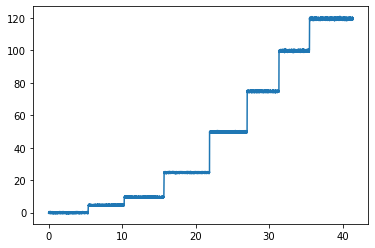

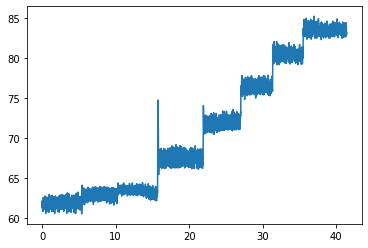

In [7]:
plot_ts(data_lm10)

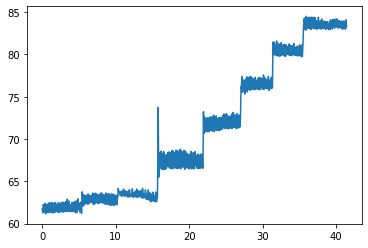

In [56]:
denoiser = Denoiser()
denoised_speed1 = denoiser.denoise(data_lm10['speed'][0], 30)
plt.plot(data_lm10['time'][0], denoised_speed1)


In [19]:
def denoise_data(data):
    w = 51
    w_t = "hamming"
    denoised_speed = smooth(data['speed'][0], window_len=w, window=w_t)
    denoised_torque = smooth(data['torque'][0], window_len=w, window=w_t)    
    plt.plot(data['time'][0], denoised_speed[w//2 :-1*w//2+1])
    plt.show()
    plt.plot(data['time'][0], denoised_torque[w//2 :-1*w//2+1])
    plt.show()
    plt.plot(data['time'][0], denoised_speed[w//2:-1*w//2+1])
    plt.plot(data['time'][0], data['speed'][0], alpha=0.4)
    plt.show()
    plt.plot(data['time'][0], denoised_torque[w//2:-1*w//2+1])
    plt.plot(data['time'][0], data['torque'][0], alpha=0.4)
    plt.show()
    return {'dspeed':data['speed'][0], 'dtorque':data['torque'][0], 'cspeed': denoised_speed[:-w+1], 'ctorque': denoised_torque[:-w+1],
            'dcurrent_d': data['current_d'][0], 'dcurrent_q': data['current_q'][0], 'dvoltage_d': data['voltage_d'][0],
           'dvoltgage_q': data['voltage_q'][0], 'dtime': data['time'][0]}

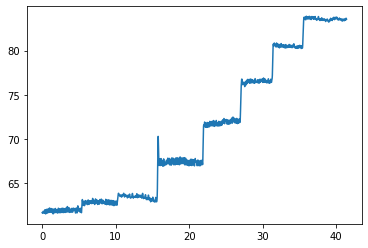

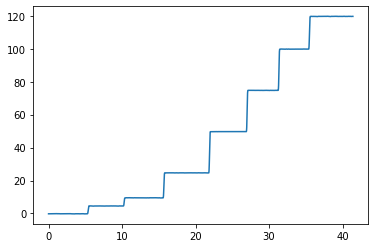

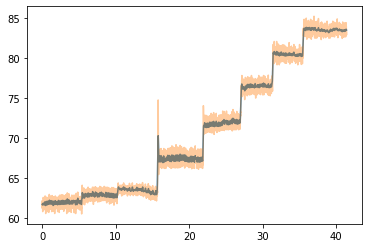

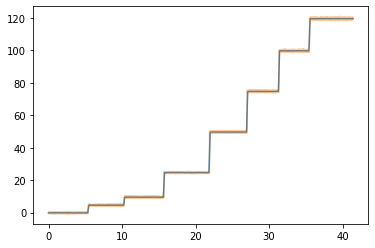

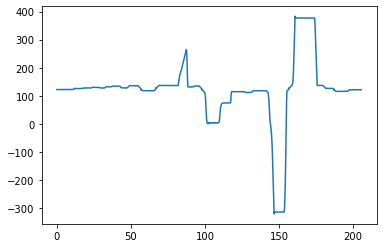

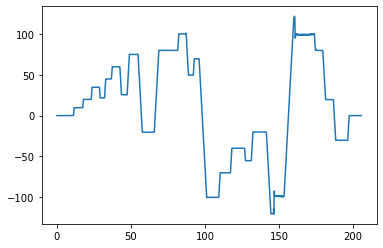

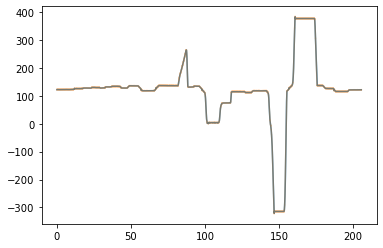

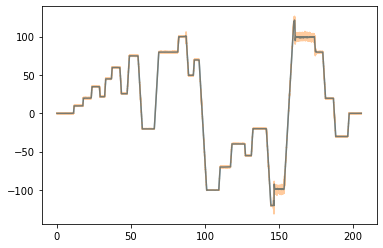

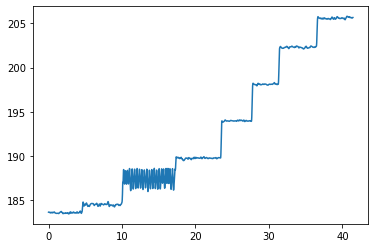

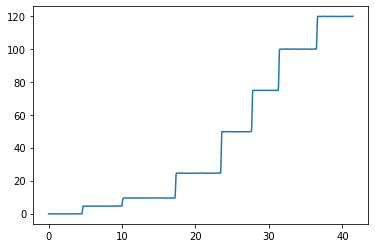

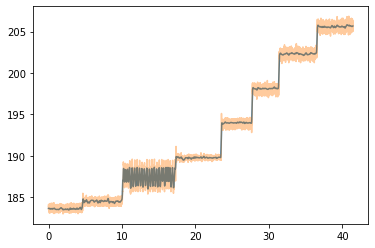

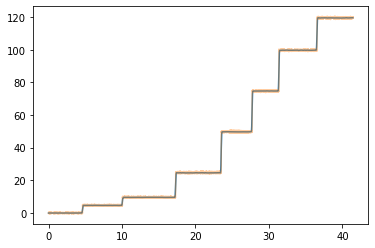

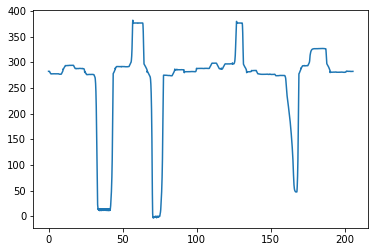

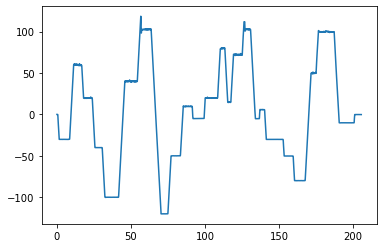

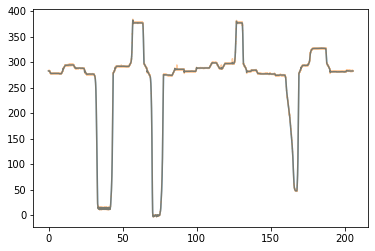

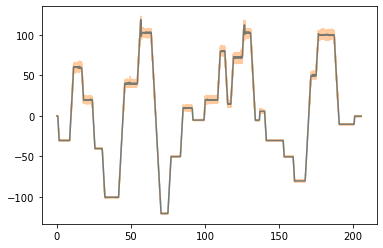

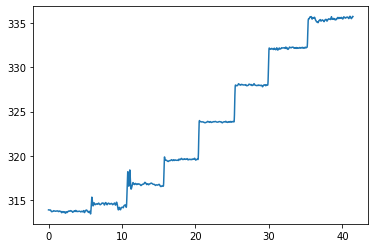

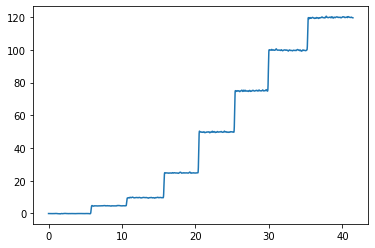

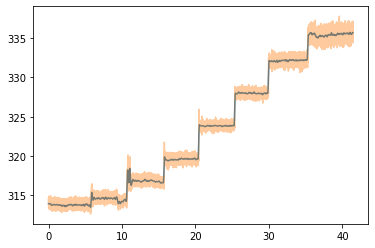

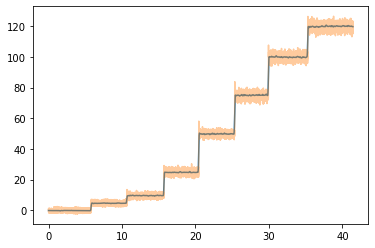

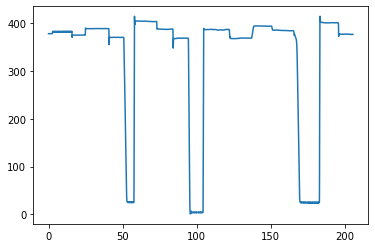

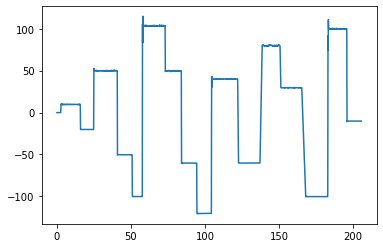

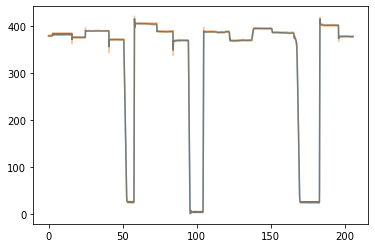

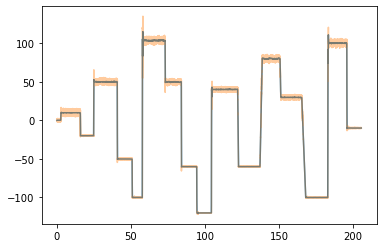

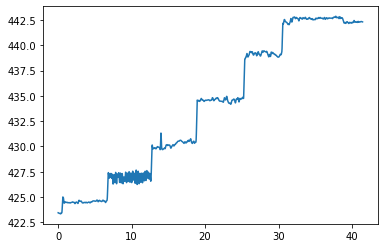

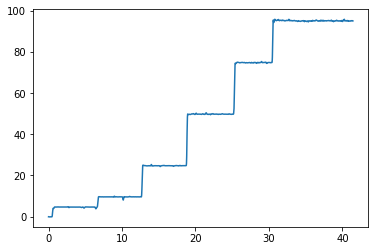

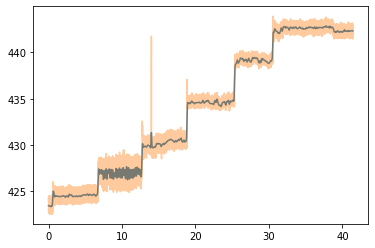

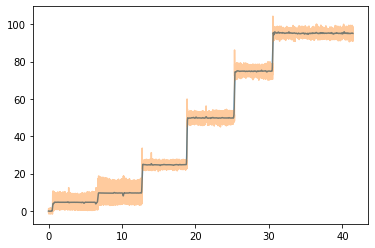

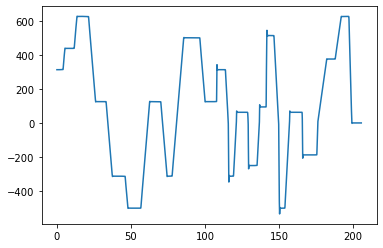

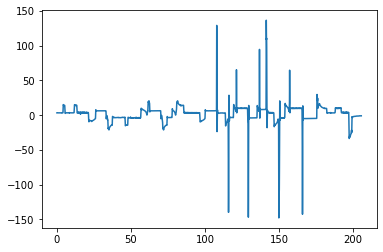

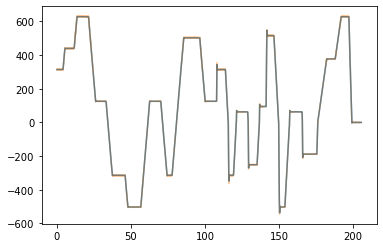

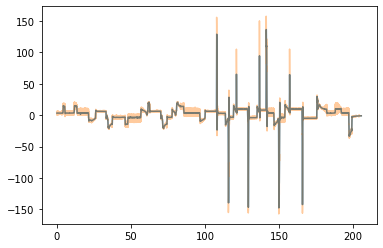

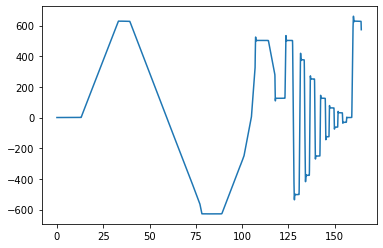

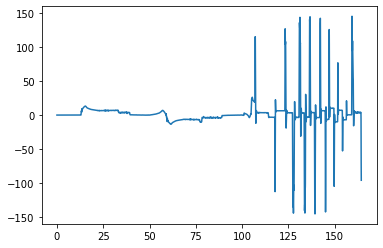

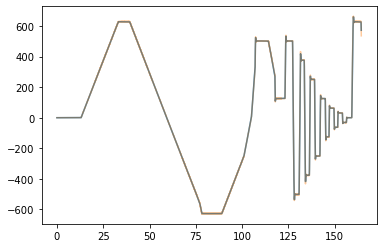

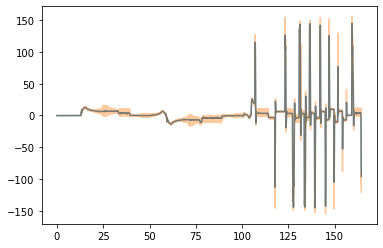

In [20]:
RES_PATH = './'
cdata_lm10             = denoise_data(data_lm10)
sio.savemat(os.path.join(RES_PATH, 'LM10.mat'), cdata_lm10)

cdata_lm20_torquesteps = denoise_data(data_lm20_torquesteps)
sio.savemat(os.path.join(RES_PATH, 'LM20_TorqueSteps.mat'), cdata_lm20_torquesteps)

cdata_lm30             = denoise_data(data_lm30)
sio.savemat(os.path.join(RES_PATH, 'LM30.mat'), cdata_lm30)


cdata_lm45_torquesteps = denoise_data(data_lm45_torquesteps)
sio.savemat(os.path.join(RES_PATH, 'LM45_TorqueSteps.mat'), cdata_lm45_torquesteps)

cdata_lm50             = denoise_data(data_lm50)
sio.savemat(os.path.join(RES_PATH, 'LM50.mat'), cdata_lm50)

cdata_lm60_torquesteps = denoise_data(data_lm60_torquesteps)
sio.savemat(os.path.join(RES_PATH, 'LM60_TorqueSteps.mat'), cdata_lm60_torquesteps)

cdata_lm68             = denoise_data(data_lm68)
sio.savemat(os.path.join(RES_PATH, 'LM68.mat'), data_lm68)

cdata_spdvar           = denoise_data(data_spdvar)
sio.savemat(os.path.join(RES_PATH, 'NoLM_SpeedVariations.mat'), cdata_spdvar)

cdata_spdvar2          = denoise_data(data_spdvar2)
sio.savemat(os.path.join(RES_PATH, 'NoLM_SpeedVariations2.mat'), cdata_spdvar2)

In [106]:
print (data['speed'][0].shape)

NameError: name 'data' is not defined